Installing required modules

In [ ]:
!pip install pdf2image
!pip install -q timm
!apt-get install -y poppler-utils
!add-apt-repository -y ppa:alex-p/tesseract-ocr-devel
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file1 ='/content/drive/MyDrive/MyDocs/Pinnacle/Pinnacle_Assignment/Pdf_Folder/Pdf_1.pdf'
file2='/content/drive/MyDrive/MyDocs/Pinnacle/Pinnacle_Assignment/Pdf_Folder/Pdf_2.pdf'
file3='/content/drive/MyDrive/MyDocs/Pinnacle/Pinnacle_Assignment/Pdf_Folder/Pdf_3.pdf'

converting pdf to image

In [ ]:
from PIL import Image
from pdf2image import convert_from_path

# file_path='/content/inv_pdf1.jpg'
image=convert_from_path(file3)
image=image[0]
image = image.convert("RGB")
width, height = image.size
# image.resize((int(width*0.5), int(height*0.5)))

Transfromer imported from huggingface for detecting location of tabular data in invoce

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1132, 800])


importing model

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

to plot datected image with masking over the table

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

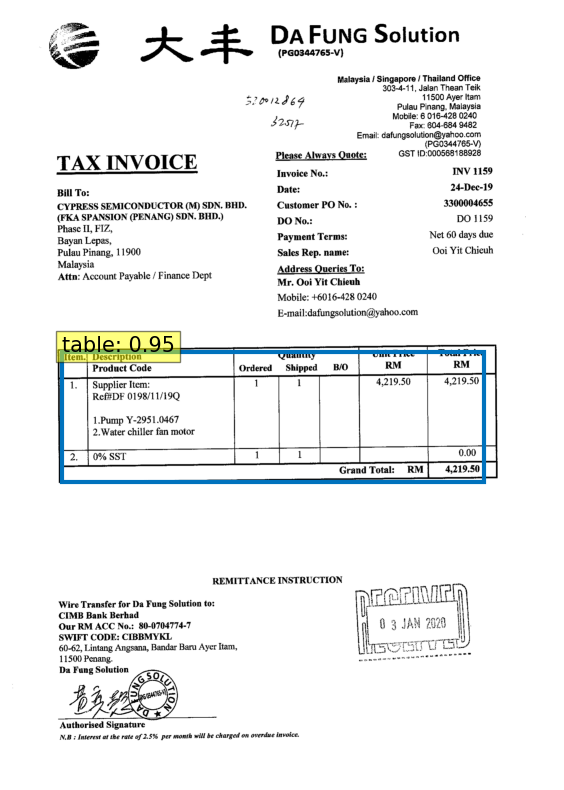

In [ ]:
plot_results(image, results['scores'], results['labels'], results['boxes'])


Cropping table from image

In [ ]:
import cv2
import numpy as np

def crop_regions(image, boxes):
    cropped_images = []
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    x_min = int(boxes[0, 0].item())
    y_min = int(boxes[0, 1].item())
    x_max = int(boxes[0, 2].item())
    y_max = int(boxes[0, 3].item())
    cropped_image = image[y_min:y_max, x_min:x_max]
    cropped_images.append(cropped_image)
    return cropped_images



In [ ]:
args = {
	"output": "/content/results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,
}

In [ ]:
cr=crop_regions(image,results['boxes'])

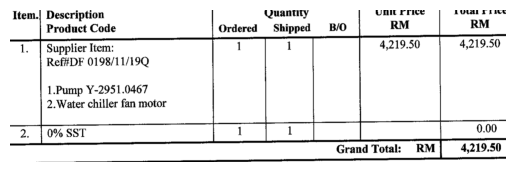

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape the image array
cr_reshaped = np.squeeze(cr)

# Display the image
plt.imshow(cr_reshaped)
plt.axis('off')
plt.show()


In [ ]:
# cr=np.array(cr)


In [ ]:
# cr.shape

In [ ]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from pdf2image import convert_from_path
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [ ]:
# set the PSM mode to detect sparse text, and then localize text in
# the table


options = "--psm 6"
results = pytesseract.image_to_data(
	cv2.cvtColor(cr_reshaped, cv2.COLOR_BGR2RGB),
	config=options,
	output_type=pytesseract.pytesseract.Output.DICT)

# initialize a list to store the (x, y)-coordinates of the detected
# text along with the OCR'd text itself
coords = []
ocrText = []

# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]

	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(float(results["conf"][i]))

	# filter out weak confidence text localizations
	if conf > args["min_conf"]:
		# update our text bounding box coordinates and OCR'd text,
		# respectively
		coords.append((x, y, w, h))
		ocrText.append(text)

In [ ]:
# extracting all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]

# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=args["dist_thresh"])
clustering.fit(xCoords)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='manhattan', distance_threshold=25.0,
                        linkage='complete', n_clusters=None)

In [ ]:
# initialize our list of sorted clusters
sortedClusters = []

# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# verify that the cluster is sufficiently large
	if len(idxs) > args["min_size"]:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [ ]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	# generate a random color for the cluster
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

	# loop over the sorted indexes
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		cv2.rectangle(cr_reshaped, (x, y), (x + w, y + h), color, 2)

	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

In [ ]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

+----+---------------+-------------+----------+----------+
|    | Description   | Code        | Unit     | SULA     |
|----+---------------+-------------+----------+----------|
|  0 | Product       | Item:       | 4,219.50 | 4,219.50 |
|  1 | Supptier      | 0198/11/19Q | Total:   | 4,219.50 |
|  2 | Ref#DF        | Y-2951.0467 |          |          |
|  3 | 1.Pump        | chiller     |          |          |
|  4 | 2.Water       |             |          |          |
+----+---------------+-------------+----------+----------+


In [ ]:
# write our table data to drive as a CSV file
print("[INFO] saving CSV file to disk...")
df.to_csv(args["output"], index=False)



[INFO] saving CSV file to disk...


# Refrences:

trnsformer huggingface: https://github.com/huggingface/transformers.git